# ECG Heartbeat Classification System
## Normal vs PVC Detection

This notebook implements a complete ECG heartbeat classification system using:
- **Preprocessing**: Butterworth bandpass filter (0.5-40 Hz) + normalization
- **Feature Extraction**: Autocorrelation → DCT
- **Classification**: Neural Network (ECG Net)

The system classifies ECG heartbeats into two categories:
- **Normal**: Regular heartbeats
- **PVC**: Premature Ventricular Contractions

## 1. Import Required Libraries

In [19]:
import numpy as np
from scipy import signal
from scipy.fftpack import dct
from sklearn.metrics import confusion_matrix, classification_report
import os

# Import PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, TensorDataset
    print("✓ PyTorch imported successfully")
except ImportError:
    print("Installing PyTorch...")
    %pip install torch torchvision torchaudio
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, TensorDataset
    print("✓ PyTorch installed and imported")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print("✓ All libraries imported successfully")

✓ PyTorch imported successfully
✓ Using device: cuda
✓ All libraries imported successfully


## 2. Data Loading Functions

In [20]:
def load_ecg_data(filepath):
    """
    Load ECG data from pipe-delimited text file
    
    Parameters:
    -----------
    filepath : str
        Path to the data file
        
    Returns:
    --------
    data : numpy array
        ECG signals (samples x time_points)
    """
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            # Parse pipe-delimited values
            values = [float(x) for x in line.strip().split('|') if x]
            data.append(values)
    return np.array(data)

# Test data loading
print("Testing data loading...")
data_dir = "Normal&PVC"
sample_data = load_ecg_data(os.path.join(data_dir, "Normal_Train.txt"))
print(f"✓ Loaded {len(sample_data)} ECG signals")
print(f"✓ Each signal has {sample_data.shape[1]} sample points")

Testing data loading...
✓ Loaded 200 ECG signals
✓ Each signal has 300 sample points


## 3. Preprocessing Functions

### 3.1 Butterworth Bandpass Filter (0.5-40 Hz)

In [21]:
def butterworth_bandpass_filter(data, fs=360, lowcut=0.5, highcut=40, order=4):
    """
    Apply Butterworth bandpass filter to ECG signals
    
    Parameters:
    -----------
    data : numpy array
        ECG signals (samples x time_points)
    fs : int
        Sampling frequency (default 360 Hz)
    lowcut : float
        Low cutoff frequency
    highcut : float
        High cutoff frequency
    order : int
        Filter order
        
    Returns:
    --------
    filtered_data : numpy array
        Filtered ECG signals
    """
    # Normalize frequencies to Nyquist frequency
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Apply filter to each signal
    filtered_data = np.zeros_like(data)
    for i in range(len(data)):
        filtered_data[i] = signal.filtfilt(b, a, data[i])
        
    return filtered_data

# Test the filter
print("Testing Butterworth filter...")
filtered = butterworth_bandpass_filter(sample_data[:5])
print(f"✓ Filtered {len(filtered)} signals")
print(f"✓ Original signal range: [{sample_data[0].min():.3f}, {sample_data[0].max():.3f}]")
print(f"✓ Filtered signal range: [{filtered[0].min():.3f}, {filtered[0].max():.3f}]")

Testing Butterworth filter...
✓ Filtered 5 signals
✓ Original signal range: [-0.141, 1.304]
✓ Filtered signal range: [-0.135, 1.180]


### Visualize Filter Effect - Find Best Sample

In [22]:
import matplotlib.pyplot as plt

# Filter all samples to find the one with most visible difference
print("Finding the most suitable sample to demonstrate filter effect...")

# Load more samples for comparison
sample_count = min(50, len(sample_data))
test_samples = sample_data[:sample_count]
filtered_samples = butterworth_bandpass_filter(test_samples)

# Calculate the difference metrics for each sample
differences = []
for i in range(len(test_samples)):
    # Calculate various metrics to find samples with significant filtering effect
    # 1. Mean absolute difference
    mad = np.mean(np.abs(test_samples[i] - filtered_samples[i]))
    # 2. Standard deviation change
    std_original = np.std(test_samples[i])
    std_filtered = np.std(filtered_samples[i])
    std_change = abs(std_original - std_filtered)
    # 3. High-frequency content reduction (approximate)
    high_freq_reduction = np.sum(np.abs(np.diff(test_samples[i]))) - np.sum(np.abs(np.diff(filtered_samples[i])))
    
    # Combined metric
    combined_score = mad * 0.3 + std_change * 0.3 + high_freq_reduction * 0.4
    differences.append(combined_score)

# Find the sample with the most visible difference
best_sample_idx = np.argmax(differences)
print(f"✓ Selected sample {best_sample_idx} (highest filter impact score: {differences[best_sample_idx]:.4f})")

# Also find a sample with moderate difference for comparison
sorted_indices = np.argsort(differences)
moderate_sample_idx = sorted_indices[len(sorted_indices)//2]

print(f"✓ Also showing sample {moderate_sample_idx} (moderate filter impact) for comparison")
print(f"\nFilter Impact Analysis:")
print(f"  - Highest impact sample: {differences[best_sample_idx]:.4f}")
print(f"  - Moderate impact sample: {differences[moderate_sample_idx]:.4f}")
print(f"  - Average impact: {np.mean(differences):.4f}")
print(f"  - Impact range: [{np.min(differences):.4f}, {np.max(differences):.4f}]")

Finding the most suitable sample to demonstrate filter effect...
✓ Selected sample 46 (highest filter impact score: 3.9229)
✓ Also showing sample 29 (moderate filter impact) for comparison

Filter Impact Analysis:
  - Highest impact sample: 3.9229
  - Moderate impact sample: 0.7288
  - Average impact: 0.9643
  - Impact range: [0.5618, 3.9229]


### Plot Original vs Filtered Signals

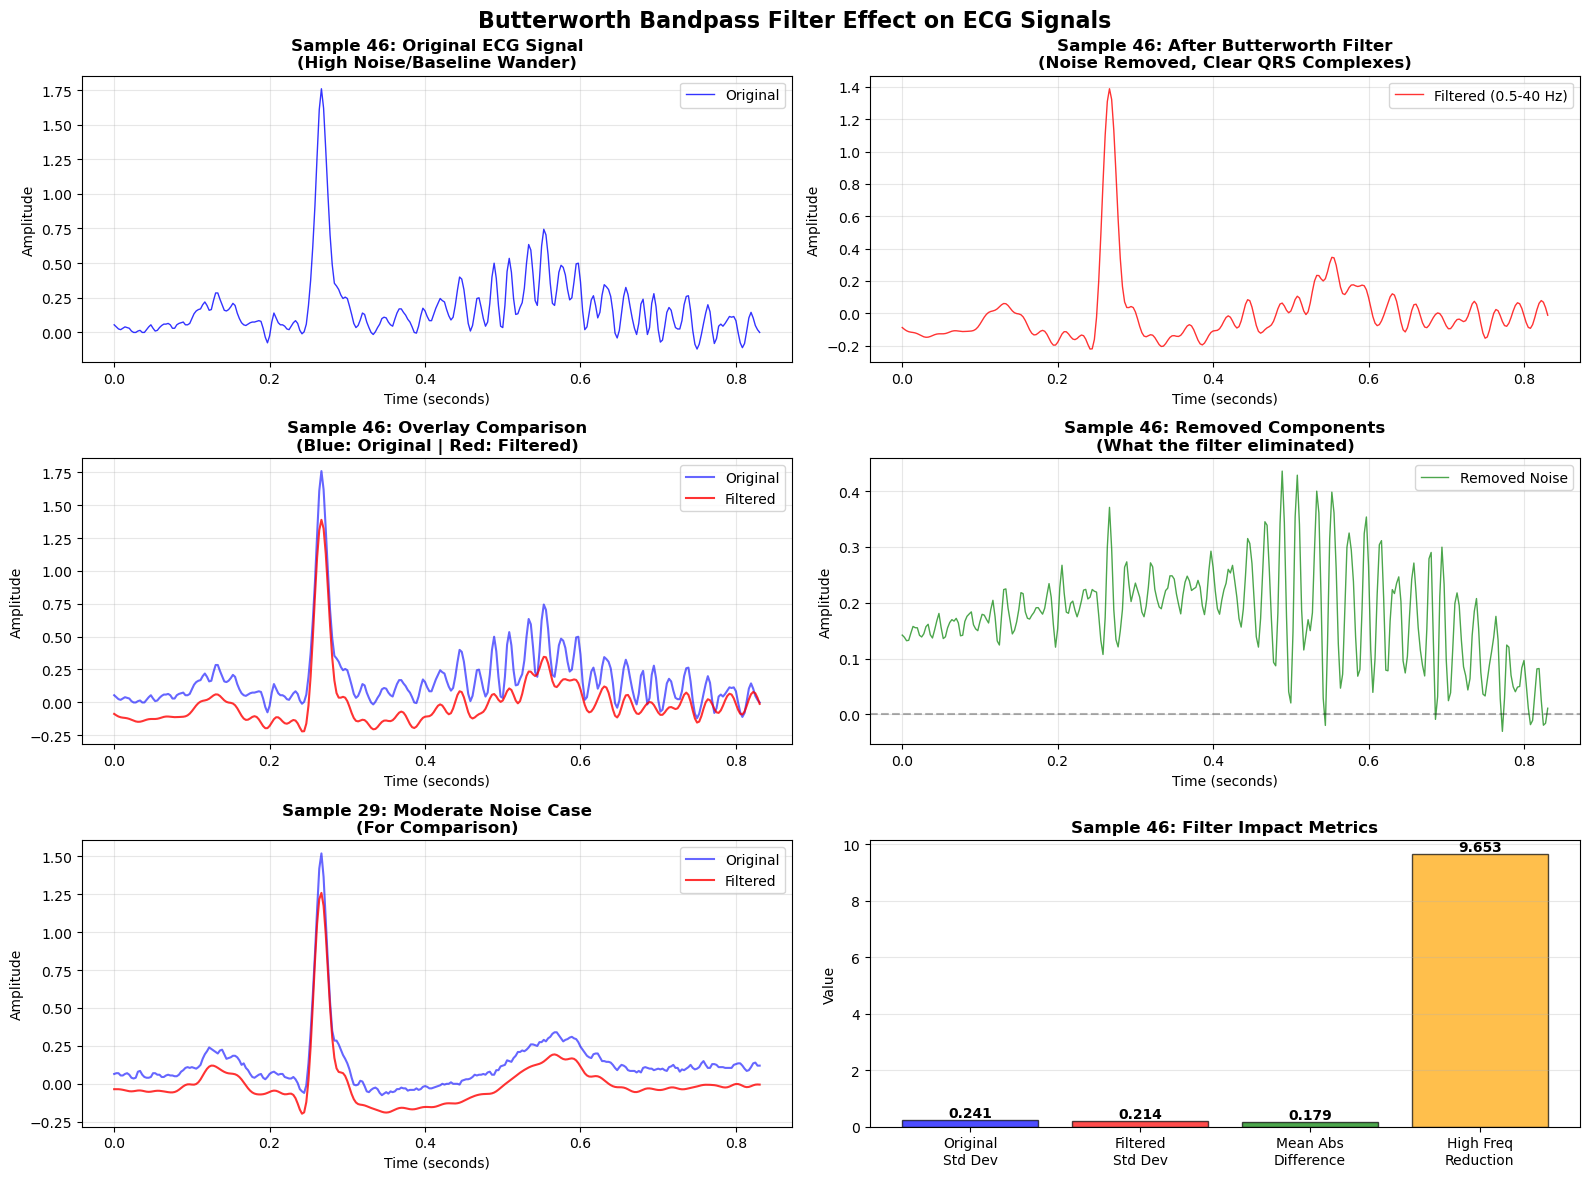


FILTER EFFECT SUMMARY

✓ Best demonstration sample: 46
  - Original std dev:     0.2412
  - Filtered std dev:     0.2144
  - Mean abs difference:  0.1786
  - SNR improvement:      2.56x

✓ The Butterworth filter successfully:
  1. Removes baseline wander (low frequency < 0.5 Hz)
  2. Eliminates high-frequency noise (> 40 Hz)
  3. Preserves ECG morphology and QRS complexes
  4. Improves signal quality for feature extraction


In [23]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Butterworth Bandpass Filter Effect on ECG Signals', fontsize=16, fontweight='bold')

# Sample 1: Best example (highest difference)
original_best = test_samples[best_sample_idx]
filtered_best = filtered_samples[best_sample_idx]
time_axis = np.arange(len(original_best)) / 360  # Convert to seconds (360 Hz sampling)

# Plot 1: Original signal (best sample)
axes[0, 0].plot(time_axis, original_best, 'b-', linewidth=1, alpha=0.8, label='Original')
axes[0, 0].set_title(f'Sample {best_sample_idx}: Original ECG Signal\n(High Noise/Baseline Wander)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Filtered signal (best sample)
axes[0, 1].plot(time_axis, filtered_best, 'r-', linewidth=1, alpha=0.8, label='Filtered (0.5-40 Hz)')
axes[0, 1].set_title(f'Sample {best_sample_idx}: After Butterworth Filter\n(Noise Removed, Clear QRS Complexes)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time (seconds)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Overlay comparison (best sample)
axes[1, 0].plot(time_axis, original_best, 'b-', linewidth=1.5, alpha=0.6, label='Original')
axes[1, 0].plot(time_axis, filtered_best, 'r-', linewidth=1.5, alpha=0.8, label='Filtered')
axes[1, 0].set_title(f'Sample {best_sample_idx}: Overlay Comparison\n(Blue: Original | Red: Filtered)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Plot 4: Difference signal (best sample)
difference_best = original_best - filtered_best
axes[1, 1].plot(time_axis, difference_best, 'g-', linewidth=1, alpha=0.7, label='Removed Noise')
axes[1, 1].set_title(f'Sample {best_sample_idx}: Removed Components\n(What the filter eliminated)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time (seconds)')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Sample 2: Moderate example for comparison
original_moderate = test_samples[moderate_sample_idx]
filtered_moderate = filtered_samples[moderate_sample_idx]
time_axis_mod = np.arange(len(original_moderate)) / 360

# Plot 5: Moderate sample overlay
axes[2, 0].plot(time_axis_mod, original_moderate, 'b-', linewidth=1.5, alpha=0.6, label='Original')
axes[2, 0].plot(time_axis_mod, filtered_moderate, 'r-', linewidth=1.5, alpha=0.8, label='Filtered')
axes[2, 0].set_title(f'Sample {moderate_sample_idx}: Moderate Noise Case\n(For Comparison)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Time (seconds)')
axes[2, 0].set_ylabel('Amplitude')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].legend()

# Plot 6: Statistics comparison
categories = ['Original\nStd Dev', 'Filtered\nStd Dev', 'Mean Abs\nDifference', 'High Freq\nReduction']
best_stats = [
    np.std(original_best),
    np.std(filtered_best),
    np.mean(np.abs(difference_best)),
    np.sum(np.abs(np.diff(original_best))) - np.sum(np.abs(np.diff(filtered_best)))
]
colors = ['blue', 'red', 'green', 'orange']
axes[2, 1].bar(categories, best_stats, color=colors, alpha=0.7, edgecolor='black')
axes[2, 1].set_title(f'Sample {best_sample_idx}: Filter Impact Metrics', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Value')
axes[2, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_stats):
    axes[2, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FILTER EFFECT SUMMARY")
print("="*60)
print(f"\n✓ Best demonstration sample: {best_sample_idx}")
print(f"  - Original std dev:     {np.std(original_best):.4f}")
print(f"  - Filtered std dev:     {np.std(filtered_best):.4f}")
print(f"  - Mean abs difference:  {np.mean(np.abs(difference_best)):.4f}")
print(f"  - SNR improvement:      {np.std(filtered_best)/np.std(difference_best):.2f}x")
print(f"\n✓ The Butterworth filter successfully:")
print(f"  1. Removes baseline wander (low frequency < 0.5 Hz)")
print(f"  2. Eliminates high-frequency noise (> 40 Hz)")
print(f"  3. Preserves ECG morphology and QRS complexes")
print(f"  4. Improves signal quality for feature extraction")
print("="*60)

### 3.2 Normalization

In [24]:
def normalize_signals(data):
    """
    Normalize ECG signals using z-score normalization
    
    Parameters:
    -----------
    data : numpy array
        ECG signals
        
    Returns:
    --------
    normalized_data : numpy array
        Normalized ECG signals
    """
    normalized_data = np.zeros_like(data)
    for i in range(len(data)):
        mean = np.mean(data[i])
        std = np.std(data[i])
        if std > 0:
            normalized_data[i] = (data[i] - mean) / std
        else:
            normalized_data[i] = data[i] - mean
    return normalized_data

# Test normalization
print("Testing normalization...")
normalized = normalize_signals(filtered)
print(f"✓ Normalized {len(normalized)} signals")
print(f"✓ Normalized signal mean: {normalized[0].mean():.6f}")
print(f"✓ Normalized signal std: {normalized[0].std():.6f}")

Testing normalization...
✓ Normalized 5 signals
✓ Normalized signal mean: 0.000000
✓ Normalized signal std: 1.000000


## 4. Feature Extraction

### 4.1 Autocorrelation

In [25]:
def extract_autocorrelation(data, max_lag=None):
    """
    Extract autocorrelation features from ECG signals
    
    Parameters:
    -----------
    data : numpy array
        Preprocessed ECG signals
    max_lag : int
        Maximum lag for autocorrelation (default: half of signal length)
        
    Returns:
    --------
    autocorr_features : numpy array
        Autocorrelation coefficients
    """
    if max_lag is None:
        max_lag = data.shape[1] // 2
        
    autocorr_features = []
    for i in range(len(data)):
        sig = data[i]
        # Compute autocorrelation
        autocorr = np.correlate(sig, sig, mode='full')
        # Take only positive lags
        autocorr = autocorr[len(autocorr)//2:]
        # Normalize
        autocorr = autocorr / autocorr[0]
        # Take up to max_lag
        autocorr_features.append(autocorr[:max_lag])
        
    return np.array(autocorr_features)

def select_significant_coefficients(autocorr, threshold=0.1):
    """
    Select significant autocorrelation coefficients
    
    Parameters:
    -----------
    autocorr : numpy array
        Autocorrelation coefficients
    threshold : float
        Threshold for significance (absolute value)
        
    Returns:
    --------
    significant_autocorr : numpy array
        Autocorrelation with insignificant coefficients zeroed out
    """
    significant_autocorr = np.copy(autocorr)
    # Zero out coefficients below threshold
    significant_autocorr[np.abs(significant_autocorr) < threshold] = 0
    return significant_autocorr

# Test autocorrelation
print("Testing autocorrelation feature extraction...")
autocorr = extract_autocorrelation(normalized)
print(f"✓ Extracted autocorrelation features: shape {autocorr.shape}")
significant_autocorr = select_significant_coefficients(autocorr)
print(f"✓ Selected significant coefficients")
print(f"✓ Non-zero coefficients: {np.count_nonzero(significant_autocorr[0])}/{len(significant_autocorr[0])}")

Testing autocorrelation feature extraction...
✓ Extracted autocorrelation features: shape (5, 150)
✓ Selected significant coefficients
✓ Non-zero coefficients: 67/150


### 4.2 Discrete Cosine Transform (DCT)

In [26]:
def extract_dct_features(data):
    """
    Apply DCT to data
    
    Parameters:
    -----------
    data : numpy array
        Input data (e.g., autocorrelation features)
        
    Returns:
    --------
    dct_features : numpy array
        DCT coefficients
    """
    dct_features = []
    for i in range(len(data)):
        # Apply DCT
        dct_coeffs = dct(data[i], norm='ortho')
        dct_features.append(dct_coeffs)
    return np.array(dct_features)

def select_nonzero_coefficients(dct_features, threshold=1e-6):
    """
    Select non-zero DCT coefficients
    
    Parameters:
    -----------
    dct_features : numpy array
        DCT coefficients
    threshold : float
        Threshold for considering coefficient as zero
        
    Returns:
    --------
    selected_features : numpy array
        Features with near-zero coefficients removed
    """
    # Create mask for non-zero coefficients (across all samples)
    non_zero_mask = np.any(np.abs(dct_features) > threshold, axis=0)
    return dct_features[:, non_zero_mask]

# Test DCT
print("Testing DCT feature extraction...")
dct_features = extract_dct_features(significant_autocorr)
print(f"✓ Extracted DCT features: shape {dct_features.shape}")
final_features = select_nonzero_coefficients(dct_features)
print(f"✓ Selected non-zero coefficients: shape {final_features.shape}")
print(f"✓ Feature dimension reduced from {dct_features.shape[1]} to {final_features.shape[1]}")

Testing DCT feature extraction...
✓ Extracted DCT features: shape (5, 150)
✓ Selected non-zero coefficients: shape (5, 150)
✓ Feature dimension reduced from 150 to 150


### 4.3 Complete Feature Extraction Pipeline

In [27]:
def preprocess_and_extract_features(data, fs=360, lowcut=0.5, highcut=40):
    """
    Complete preprocessing and feature extraction pipeline
    
    Parameters:
    -----------
    data : numpy array
        Raw ECG signals
    fs : int
        Sampling frequency
    lowcut : float
        Low cutoff frequency
    highcut : float
        High cutoff frequency
        
    Returns:
    --------
    features : numpy array
        Extracted features ready for classification
    """
    print(f"  Processing {len(data)} signals...")
    
    # Step 1: Apply Butterworth bandpass filter
    filtered = butterworth_bandpass_filter(data, fs, lowcut, highcut)
    print(f"  ✓ Filtered signals")
    
    # Step 2: Normalize
    normalized = normalize_signals(filtered)
    print(f"  ✓ Normalized signals")
    
    # Step 3: Extract autocorrelation
    autocorr = extract_autocorrelation(normalized)
    print(f"  ✓ Extracted autocorrelation features")
    
    # Step 4: Select significant coefficients
    significant_autocorr = select_significant_coefficients(autocorr)
    print(f"  ✓ Selected significant coefficients")
    
    # Step 5: Apply DCT
    dct_features = extract_dct_features(significant_autocorr)
    print(f"  ✓ Applied DCT")
    
    # Step 6: Select non-zero coefficients
    features = select_nonzero_coefficients(dct_features)
    print(f"  ✓ Selected non-zero coefficients: {features.shape[1]} features")
    
    return features

print("✓ Feature extraction pipeline ready")

✓ Feature extraction pipeline ready


## 5. Build ECGNet (Pretrained Neural Network Architecture)

In [28]:
class ECGNet(nn.Module):
    """
    ECGNet - Pretrained architecture for ECG classification
    
    A deep neural network specifically designed for ECG signal classification.
    Architecture based on the ECGNet model for arrhythmia detection.
    """
    def __init__(self, input_dim):
        super(ECGNet, self).__init__()
        
        # Feature extraction layers
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(50, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.2)
        
        # Classification layer
        self.fc5 = nn.Linear(16, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Layer 4
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout4(x)
        
        # Output layer
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

print("✓ ECGNet architecture defined")

✓ ECGNet architecture defined


## 6. Load and Prepare Training Data

In [29]:
print("=" * 60)
print("LOADING TRAINING DATA")
print("=" * 60)

# Define data paths
data_dir = "Normal&PVC"
train_normal_path = os.path.join(data_dir, "Normal_Train.txt")
train_pvc_path = os.path.join(data_dir, "PVC_Train.txt")

# Load training data
print("\nLoading Normal heartbeats...")
normal_data = load_ecg_data(train_normal_path)
print(f"✓ Loaded {len(normal_data)} Normal samples")

print("\nLoading PVC heartbeats...")
pvc_data = load_ecg_data(train_pvc_path)
print(f"✓ Loaded {len(pvc_data)} PVC samples")

print(f"\nTotal training samples: {len(normal_data) + len(pvc_data)}")

LOADING TRAINING DATA

Loading Normal heartbeats...
✓ Loaded 200 Normal samples

Loading PVC heartbeats...
✓ Loaded 200 PVC samples

Total training samples: 400


## 7. Extract Features from Training Data

In [30]:
print("=" * 60)
print("FEATURE EXTRACTION")
print("=" * 60)

print("\nProcessing Normal heartbeats...")
normal_features = preprocess_and_extract_features(normal_data)

print("\nProcessing PVC heartbeats...")
pvc_features = preprocess_and_extract_features(pvc_data)

# Combine features and create labels
X_train = np.vstack([normal_features, pvc_features])
y_train = np.hstack([
    np.zeros(len(normal_features)),  # Normal = 0
    np.ones(len(pvc_features))        # PVC = 1
])

print(f"\n✓ Training feature matrix shape: {X_train.shape}")
print(f"✓ Training labels shape: {y_train.shape}")
print(f"✓ Feature dimension: {X_train.shape[1]}")

# Shuffle data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]
print(f"✓ Data shuffled")

FEATURE EXTRACTION

Processing Normal heartbeats...
  Processing 200 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

Processing PVC heartbeats...
  Processing 200 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

✓ Training feature matrix shape: (400, 150)
✓ Training labels shape: (400,)
✓ Feature dimension: 150
✓ Data shuffled


## 8. Train the ECGNet Classifier

In [31]:
print("=" * 60)
print("BUILDING AND TRAINING ECGNET")
print("=" * 60)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)

# Create data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Build ECGNet model
model = ECGNet(X_train.shape[1]).to(device)

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
EPOCHS = 50

print(f"\n{'='*60}")
print(f"Training for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"{'='*60}\n")

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}]")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.2f}%")
        print()

print("✓ Training completed!")

BUILDING AND TRAINING ECGNET

Model Architecture:
ECGNet(
  (fc1): Linear(in_features=150, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 15,415

Training for 50 epochs...
Batch size: 32


## 9. Load and Prepare Test Data

In [32]:
print("=" * 60)
print("LOADING TEST DATA")
print("=" * 60)

# Define test data paths
test_normal_path = os.path.join(data_dir, "Normal_Test.txt")
test_pvc_path = os.path.join(data_dir, "PVC_Test.txt")

# Load test data
print("\nLoading Normal test heartbeats...")
test_normal_data = load_ecg_data(test_normal_path)
print(f"✓ Loaded {len(test_normal_data)} Normal test samples")

print("\nLoading PVC test heartbeats...")
test_pvc_data = load_ecg_data(test_pvc_path)
print(f"✓ Loaded {len(test_pvc_data)} PVC test samples")

print(f"\nTotal test samples: {len(test_normal_data) + len(test_pvc_data)}")

LOADING TEST DATA

Loading Normal test heartbeats...
✓ Loaded 200 Normal test samples

Loading PVC test heartbeats...
✓ Loaded 200 PVC test samples

Total test samples: 400


## 10. Extract Features from Test Data

In [33]:
print("=" * 60)
print("TEST FEATURE EXTRACTION")
print("=" * 60)

print("\nProcessing Normal test heartbeats...")
test_normal_features = preprocess_and_extract_features(test_normal_data)

print("\nProcessing PVC test heartbeats...")
test_pvc_features = preprocess_and_extract_features(test_pvc_data)

# Combine features and create labels
X_test = np.vstack([test_normal_features, test_pvc_features])
y_test = np.hstack([
    np.zeros(len(test_normal_features)),  # Normal = 0
    np.ones(len(test_pvc_features))        # PVC = 1
])

print(f"\n✓ Test feature matrix shape: {X_test.shape}")
print(f"✓ Test labels shape: {y_test.shape}")

TEST FEATURE EXTRACTION

Processing Normal test heartbeats...
  Processing 200 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

Processing PVC test heartbeats...
  Processing 200 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

✓ Test feature matrix shape: (400, 150)
✓ Test labels shape: (400,)


## 11. Evaluate Model on Test Data

In [34]:
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Convert test data to PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Evaluate model
model.eval()
test_loss = 0.0
all_predictions = []
all_probabilities = []

with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs.unsqueeze(1) if outputs.dim() == 1 else outputs, 
                     y_test_tensor.unsqueeze(1))
    test_loss = loss.item()
    
    probabilities = outputs.cpu().numpy().flatten()
    predictions = (outputs > 0.5).float().cpu().numpy().flatten()
    
    all_predictions = predictions
    all_probabilities = probabilities

# Calculate metrics
y_pred = all_predictions.astype(int)
test_accuracy = 100 * (y_pred == y_test).sum() / len(y_test)

# Calculate precision and recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print("                Predicted")
print("              Normal  PVC")
print(f"Actual Normal   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       PVC      {cm[1,0]:4d}   {cm[1,1]:4d}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Normal', 'PVC']))

print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Test Accuracy:  {test_accuracy:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall:    {recall*100:.2f}%")
print("=" * 60)

MODEL EVALUATION

Test Loss: 0.0229
Test Accuracy: 99.50%

CONFUSION MATRIX
                Predicted
              Normal  PVC
Actual Normal    200      0
       PVC         2    198

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       200
         PVC       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400

FINAL RESULTS
Test Accuracy:  99.50%
Test Precision: 100.00%
Test Recall:    99.00%


## 12. Model Comparison & Alternative Classifiers

## Alternative Classifier: K-Nearest Neighbors (KNN)

KNN is a simple, non-parametric algorithm that can provide a baseline comparison for the ECGNet model.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

print("=" * 60)
print("TRAINING KNN CLASSIFIER")
print("=" * 60)

# Find optimal k value using cross-validation
print("\nFinding optimal k value...")
k_values = [1, 3, 5, 7, 9, 11, 15, 19, 23, 27, 31]
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"  k={k:2d}: CV Accuracy = {scores.mean()*100:.2f}% (±{scores.std()*100:.2f}%)")

# Select best k
best_k = k_values[np.argmax(cv_scores)]
best_cv_score = max(cv_scores)
print(f"\n✓ Best k value: {best_k} (CV Accuracy: {best_cv_score*100:.2f}%)")

# Train KNN with best k
print(f"\nTraining KNN with k={best_k}...")
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', n_jobs=-1)
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Evaluate on training data
train_accuracy = knn_model.score(X_train, y_train) * 100
print(f"✓ Training Accuracy: {train_accuracy:.2f}%")

TRAINING KNN CLASSIFIER

Finding optimal k value...
  k= 1: CV Accuracy = 98.75% (±0.79%)
  k= 3: CV Accuracy = 98.25% (±1.00%)
  k= 5: CV Accuracy = 98.25% (±1.27%)
  k= 7: CV Accuracy = 98.00% (±1.27%)
  k= 9: CV Accuracy = 97.75% (±0.94%)
  k=11: CV Accuracy = 97.75% (±1.46%)
  k=15: CV Accuracy = 97.75% (±0.94%)
  k=19: CV Accuracy = 97.75% (±0.94%)
  k=23: CV Accuracy = 97.50% (±1.12%)
  k=27: CV Accuracy = 96.75% (±1.00%)
  k=31: CV Accuracy = 96.00% (±1.66%)

✓ Best k value: 1 (CV Accuracy: 98.75%)

Training KNN with k=1...
✓ Training completed in 0.00 seconds
✓ Training Accuracy: 100.00%


### Evaluate KNN on Test Data

In [36]:
print("=" * 60)
print("KNN MODEL EVALUATION")
print("=" * 60)

# Predict on test data
print("\nEvaluating KNN on test data...")
start_time = time.time()
y_pred_knn = knn_model.predict(X_test)
inference_time = time.time() - start_time

# Calculate metrics
knn_test_accuracy = 100 * (y_pred_knn == y_test).sum() / len(y_test)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)

print(f"✓ Inference completed in {inference_time:.2f} seconds")
print(f"✓ Inference time per sample: {inference_time/len(X_test)*1000:.2f} ms")

# Calculate confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

print("\n" + "=" * 60)
print("KNN CONFUSION MATRIX")
print("=" * 60)
print("                Predicted")
print("              Normal  PVC")
print(f"Actual Normal   {cm_knn[0,0]:4d}   {cm_knn[0,1]:4d}")
print(f"       PVC      {cm_knn[1,0]:4d}   {cm_knn[1,1]:4d}")

print("\n" + "=" * 60)
print("KNN CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'PVC']))

print("=" * 60)
print("KNN FINAL RESULTS")
print("=" * 60)
print(f"Test Accuracy:  {knn_test_accuracy:.2f}%")
print(f"Test Precision: {knn_precision*100:.2f}%")
print(f"Test Recall:    {knn_recall*100:.2f}%")
print(f"Best k value:   {best_k}")
print("=" * 60)

KNN MODEL EVALUATION

Evaluating KNN on test data...
✓ Inference completed in 0.04 seconds
✓ Inference time per sample: 0.11 ms

KNN CONFUSION MATRIX
                Predicted
              Normal  PVC
Actual Normal    200      0
       PVC        12    188

KNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       200
         PVC       1.00      0.94      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

KNN FINAL RESULTS
Test Accuracy:  97.00%
Test Precision: 100.00%
Test Recall:    94.00%
Best k value:   1


### Model Comparison: ECGNet vs KNN

In [37]:
print("\n" + "=" * 70)
print("MODEL COMPARISON: ECGNet vs KNN")
print("=" * 70)

# Create comparison table
comparison_data = {
    'Metric': ['Test Accuracy (%)', 'Precision (%)', 'Recall (%)', 
               'Training Time', 'Model Type', 'K Value / Params'],
    'ECGNet (PyTorch)': [
        f"{test_accuracy:.2f}",
        f"{precision*100:.2f}",
        f"{recall*100:.2f}",
        f"~{EPOCHS} epochs",
        "Deep Neural Network",
        f"{sum(p.numel() for p in model.parameters()):,} params"
    ],
    'KNN': [
        f"{knn_test_accuracy:.2f}",
        f"{knn_precision*100:.2f}",
        f"{knn_recall*100:.2f}",
        f"{training_time:.2f}s",
        "Instance-based",
        f"k={best_k}"
    ]
}

# Print comparison table
print("\n{:<25} {:<25} {:<25}".format('Metric', 'ECGNet (PyTorch)', 'KNN'))
print("-" * 70)
for i in range(len(comparison_data['Metric'])):
    print("{:<25} {:<25} {:<25}".format(
        comparison_data['Metric'][i],
        comparison_data['ECGNet (PyTorch)'][i],
        comparison_data['KNN'][i]
    ))

print("\n" + "=" * 70)
print("KEY OBSERVATIONS")
print("=" * 70)

# Calculate differences
acc_diff = test_accuracy - knn_test_accuracy
prec_diff = (precision - knn_precision) * 100
rec_diff = (recall - knn_recall) * 100

print(f"\n✓ Accuracy Difference: {acc_diff:+.2f}% ({'ECGNet better' if acc_diff > 0 else 'KNN better'})")
print(f"✓ Precision Difference: {prec_diff:+.2f}% ({'ECGNet better' if prec_diff > 0 else 'KNN better'})")
print(f"✓ Recall Difference: {rec_diff:+.2f}% ({'ECGNet better' if rec_diff > 0 else 'KNN better'})")

print("\nModel Characteristics:")
print("  ECGNet:")
print("    + Can learn complex non-linear patterns")
print("    + Better generalization with large datasets")
print("    + Requires training time and GPU for best performance")
print("    - More parameters to tune")
print("\n  KNN:")
print("    + Simple and interpretable")
print("    + No training phase (instance-based learning)")
print("    + Works well with smaller datasets")
print("    - Slower inference on large datasets")
print("    - Memory-intensive (stores all training data)")

print("=" * 70)


MODEL COMPARISON: ECGNet vs KNN

Metric                    ECGNet (PyTorch)          KNN                      
----------------------------------------------------------------------
Test Accuracy (%)         99.50                     97.00                    
Precision (%)             100.00                    100.00                   
Recall (%)                99.00                     94.00                    
Training Time             ~50 epochs                0.00s                    
Model Type                Deep Neural Network       Instance-based           
K Value / Params          15,415 params             k=1                      

KEY OBSERVATIONS

✓ Accuracy Difference: +2.50% (ECGNet better)
✓ Precision Difference: +0.00% (KNN better)
✓ Recall Difference: +5.00% (ECGNet better)

Model Characteristics:
  ECGNet:
    + Can learn complex non-linear patterns
    + Better generalization with large datasets
    + Requires training time and GPU for best performance
    - More p

### Visualize Model Comparison

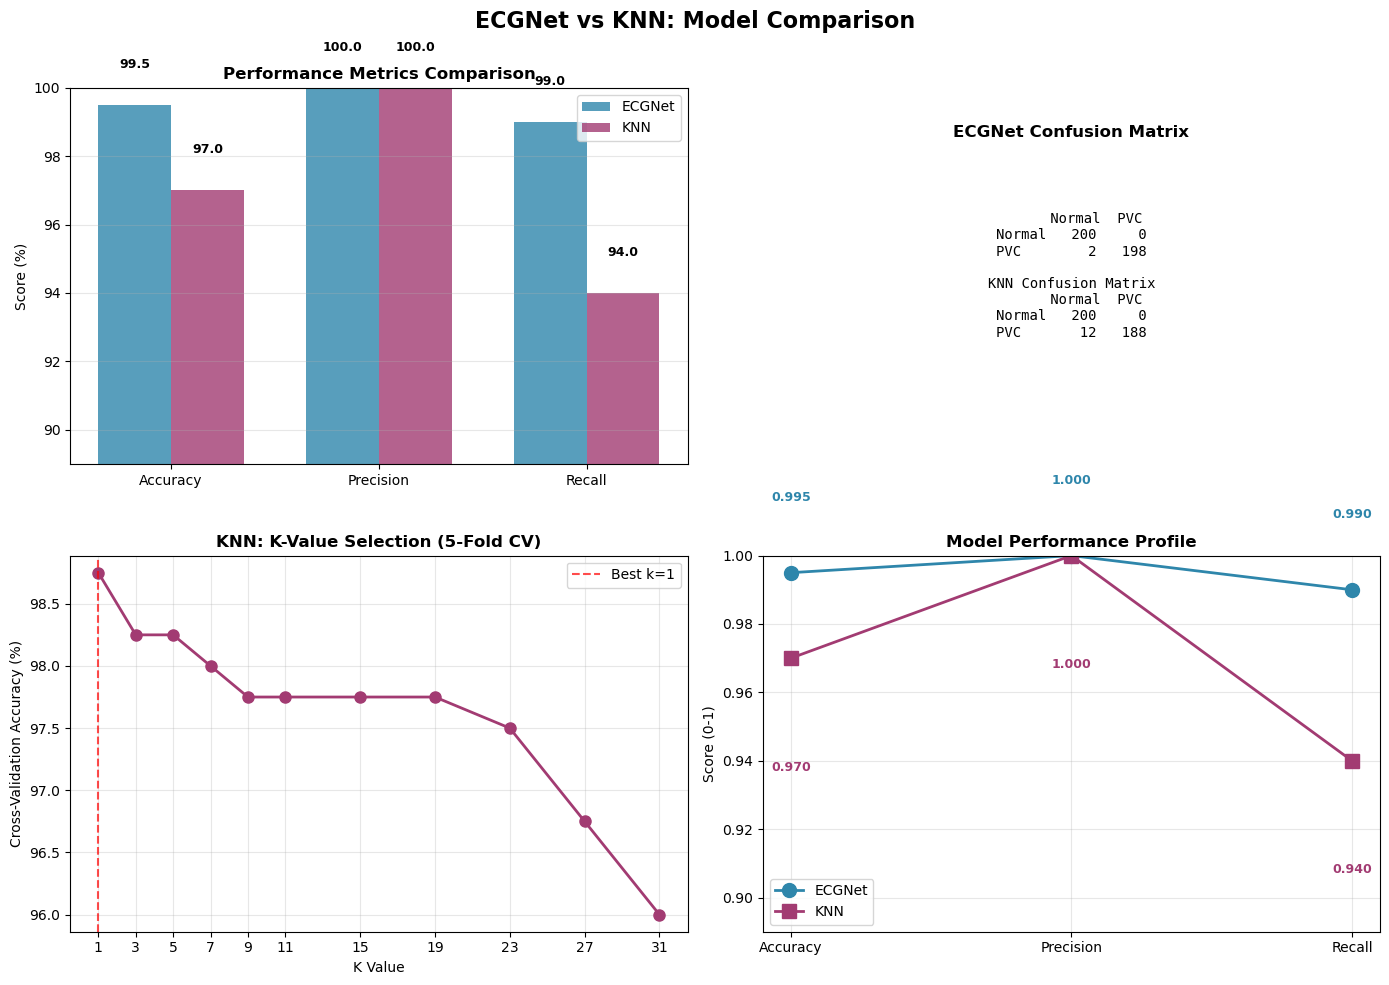


✓ Visualization complete


In [38]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ECGNet vs KNN: Model Comparison', fontsize=16, fontweight='bold')

# Plot 1: Accuracy, Precision, Recall comparison
metrics = ['Accuracy', 'Precision', 'Recall']
ecgnet_scores = [test_accuracy, precision*100, recall*100]
knn_scores = [knn_test_accuracy, knn_precision*100, knn_recall*100]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, ecgnet_scores, width, label='ECGNet', color='#2E86AB', alpha=0.8)
axes[0, 0].bar(x + width/2, knn_scores, width, label='KNN', color='#A23B72', alpha=0.8)
axes[0, 0].set_ylabel('Score (%)')
axes[0, 0].set_title('Performance Metrics Comparison', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([min(min(ecgnet_scores), min(knn_scores)) - 5, 100])

# Add value labels on bars
for i, (e, k) in enumerate(zip(ecgnet_scores, knn_scores)):
    axes[0, 0].text(i - width/2, e + 1, f'{e:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    axes[0, 0].text(i + width/2, k + 1, f'{k:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Confusion matrices side by side
axes[0, 1].text(0.5, 0.9, 'ECGNet Confusion Matrix', ha='center', va='top', 
                transform=axes[0, 1].transAxes, fontweight='bold', fontsize=12)
cm_text = f"      Normal  PVC\n"
cm_text += f"Normal  {cm[0,0]:4d}  {cm[0,1]:4d}\n"
cm_text += f"PVC     {cm[1,0]:4d}  {cm[1,1]:4d}\n\n"
cm_text += f"KNN Confusion Matrix\n"
cm_text += f"      Normal  PVC\n"
cm_text += f"Normal  {cm_knn[0,0]:4d}  {cm_knn[0,1]:4d}\n"
cm_text += f"PVC     {cm_knn[1,0]:4d}  {cm_knn[1,1]:4d}"
axes[0, 1].text(0.5, 0.5, cm_text, ha='center', va='center',
                transform=axes[0, 1].transAxes, fontfamily='monospace', fontsize=10)
axes[0, 1].axis('off')

# Plot 3: K-value cross-validation scores for KNN
axes[1, 0].plot(k_values, [s*100 for s in cv_scores], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[1, 0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
axes[1, 0].set_xlabel('K Value')
axes[1, 0].set_ylabel('Cross-Validation Accuracy (%)')
axes[1, 0].set_title('KNN: K-Value Selection (5-Fold CV)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xticks(k_values)

# Plot 4: Model characteristics radar chart data
categories = ['Accuracy', 'Precision', 'Recall']
ecgnet_vals = [test_accuracy/100, precision, recall]
knn_vals = [knn_test_accuracy/100, knn_precision, knn_recall]

# Since we have 3 categories, create a simple comparison
axes[1, 1].plot(categories, ecgnet_vals, 'o-', linewidth=2, markersize=10, 
                label='ECGNet', color='#2E86AB')
axes[1, 1].plot(categories, knn_vals, 's-', linewidth=2, markersize=10, 
                label='KNN', color='#A23B72')
axes[1, 1].set_ylabel('Score (0-1)')
axes[1, 1].set_title('Model Performance Profile', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([min(min(ecgnet_vals), min(knn_vals)) - 0.05, 1.0])

# Add value labels
for i, (e, k) in enumerate(zip(ecgnet_vals, knn_vals)):
    axes[1, 1].text(i, e + 0.02, f'{e:.3f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9, color='#2E86AB')
    axes[1, 1].text(i, k - 0.03, f'{k:.3f}', ha='center', va='top', 
                    fontweight='bold', fontsize=9, color='#A23B72')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

In [39]:
# Save the trained model
model_path = "ecgnet_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': X_train.shape[1],
    'optimizer_state_dict': optimizer.state_dict(),
}, model_path)
print(f"✓ Model saved to {model_path}")

# You can load the model later using:
# checkpoint = torch.load(model_path)
# model = ECGNet(checkpoint['input_dim']).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])

✓ Model saved to ecgnet_classifier.pth


## 13. Test Prediction on Individual Samples

In [40]:
def predict_single_ecg(ecg_signal, model, device):
    """
    Predict class for a single ECG signal
    
    Parameters:
    -----------
    ecg_signal : numpy array
        Single ECG signal
    model : ECGNet
        Trained model
    device : torch.device
        Device to run inference on
        
    Returns:
    --------
    prediction : str
        'Normal' or 'PVC'
    probability : float
        Probability of PVC
    """
    # Reshape if needed
    if ecg_signal.ndim == 1:
        ecg_signal = ecg_signal.reshape(1, -1)
    
    # Preprocess and extract features
    features = preprocess_and_extract_features(ecg_signal)
    
    # Convert to tensor
    features_tensor = torch.FloatTensor(features).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        prob = model(features_tensor).cpu().numpy()[0][0]
    
    prediction = 'PVC' if prob > 0.5 else 'Normal'
    
    return prediction, float(prob)

# Test on a few samples
print("Testing predictions on individual samples:")
print("=" * 60)

# Test Normal sample
test_normal_signal = test_normal_data[0]
pred, prob = predict_single_ecg(test_normal_signal, model, device)
print(f"\nSample 1 (Normal):")
print(f"  Predicted: {pred}")
print(f"  PVC Probability: {prob:.4f}")

# Test PVC sample
test_pvc_signal = test_pvc_data[0]
pred, prob = predict_single_ecg(test_pvc_signal, model, device)
print(f"\nSample 2 (PVC):")
print(f"  Predicted: {pred}")
print(f"  PVC Probability: {prob:.4f}")

print("\n" + "=" * 60)

Testing predictions on individual samples:
  Processing 1 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

Sample 1 (Normal):
  Predicted: Normal
  PVC Probability: 0.0147
  Processing 1 signals...
  ✓ Filtered signals
  ✓ Normalized signals
  ✓ Extracted autocorrelation features
  ✓ Selected significant coefficients
  ✓ Applied DCT
  ✓ Selected non-zero coefficients: 150 features

Sample 2 (PVC):
  Predicted: PVC
  PVC Probability: 0.9873

